In [15]:
import numpy as np
import gymnasium as gym

from envs import ForbiddenAreaCfg, RewardCfg
from common.policy import Policy
from common.vis import Visualizer
from common.utils import get_return, get_episode, SARPair

env = gym.make(
    "envs:gridworld-v0",
    forbidden_area_cfg=ForbiddenAreaCfg(num=6),
    reward_cfg=RewardCfg(forbidden_area=-10),
)

# MC Basic

In [16]:
policy = Policy(env)
episode_length = 30
num_episodes = 1  # due to grid world is deterministic, we only need one episode to get the expected q value.
k = 10
gamma = 0.9

size = env.unwrapped.size
states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [17]:
for _ in range(k):
    for s in states:
        q_values = np.empty(5)
        for a in range(5):  # 0: up, 1: right, 2: down, 3: left, 4: stay
            # get enough return to estimate the expected q value
            q = np.array(
                [
                    get_return(s, a, env, policy, episode_length, gamma)
                    for _ in range(num_episodes)
                ]
            )
            q_values[a] = q.mean(dtype=np.float32)
        policy.improve(s, q_values)

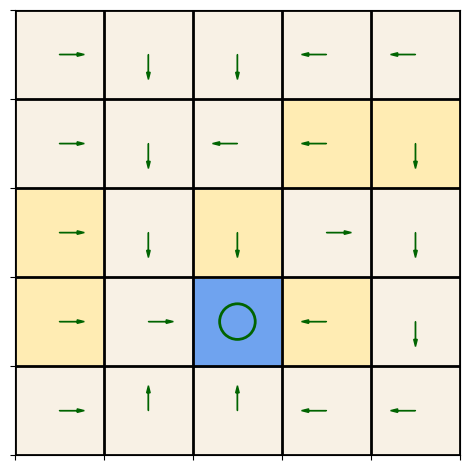

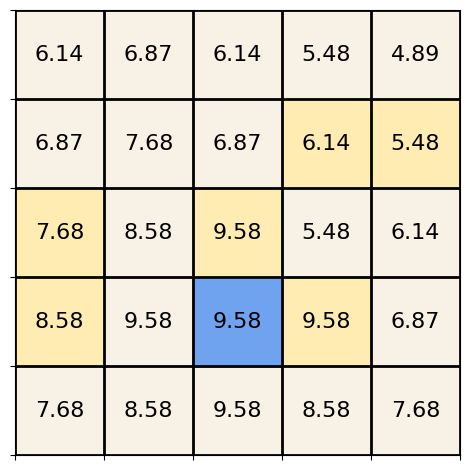

In [18]:
vis = Visualizer(env)
vis.draw_strategy(policy)
vis.draw_state_values(policy, episode_length, num_episodes, gamma)

# MC Exploring Starts

In [19]:
policy = Policy(env)
episode_length = 30
num_episodes = 1  # due to grid world is deterministic, we only need one episode to get the expected q value.
k = 10
gamma = 0.9

size = env.unwrapped.size
states = [(i, j) for i in range(size[0]) for j in range(size[1])]

In [20]:
from collections import defaultdict

returns = defaultdict(float)
num_returns = defaultdict(int)

Q = np.full((size[0], size[1], 5), np.finfo(np.float32).min, dtype=np.float32)

for _ in range(k):
    for s in states:
        for a in range(5):  # 0: up, 1: right, 2: down, 3: left, 4: stay
            # get enough return to estimate the expected q value
            episodes = [
                get_episode(s, a, env, policy, episode_length)
                for _ in range(num_episodes)
            ]
            for episode in episodes:
                g = 0.0
                # every-visit strategy
                for sar in reversed(episode):
                    s_np, a, r = sar.state, sar.action, sar.reward
                    s = tuple(s_np)
                    key = (s, a)
                    
                    g = gamma * g + r
                    returns[key] += g
                    num_returns[key] += 1
                    # Policy Evaluation
                    Q[s][a] = returns[key] / num_returns[key]
                    # Policy Improvement
                    policy.improve(s, Q[s])




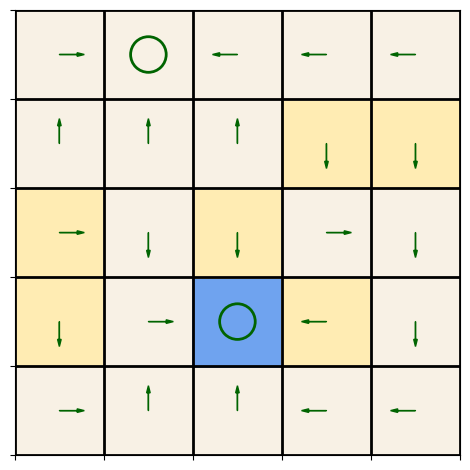

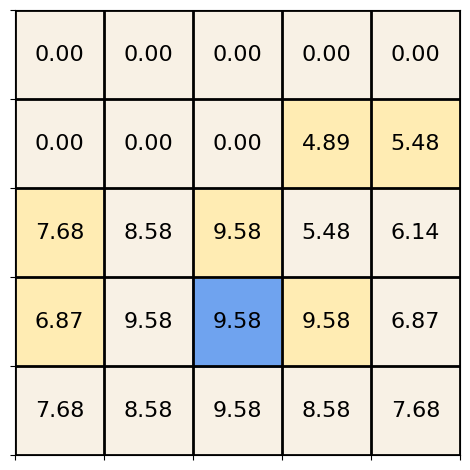

In [21]:
vis = Visualizer(env)
vis.draw_strategy(policy)
vis.draw_state_values(policy, episode_length, num_episodes, gamma)